# Predicting - Blood Donations 
## Alex Braithwaite

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [2]:
# Training set
train = pd.read_csv('train.csv')
# Test set
test = pd.read_csv('test.csv')

trainlen = len(train)
merged = pd.concat([train, test], axis = 0)

In [3]:
merged.head()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Unnamed: 0
0,1.0,98,2,50,12500,619
1,1.0,28,0,13,3250,664
2,1.0,35,1,16,4000,441
3,1.0,45,2,20,5000,160
4,0.0,77,1,24,6000,358


In [4]:
# Check for null values - Made Donation in March 2007 only column with null values
merged.isnull().sum()

Made Donation in March 2007    200
Months since First Donation      0
Months since Last Donation       0
Number of Donations              0
Total Volume Donated (c.c.)      0
Unnamed: 0                       0
dtype: int64

In [5]:
merged = merged.drop(['Unnamed: 0'], axis = 1)

In [6]:
merged.dtypes

Made Donation in March 2007    float64
Months since First Donation      int64
Months since Last Donation       int64
Number of Donations              int64
Total Volume Donated (c.c.)      int64
dtype: object

In [7]:
merged.describe()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.)
count,576.000000,776.000000,776.000000,776.000000,776.000000
mean,0.239583,34.417526,9.453608,5.557990,1389.497423
std,0.427200,24.450047,8.030935,5.841939,1460.484632
min,0.000000,2.000000,0.000000,1.000000,250.000000
25%,0.000000,16.000000,3.000000,2.000000,500.000000
50%,0.000000,28.000000,7.000000,4.000000,1000.000000
75%,0.000000,50.000000,14.000000,7.000000,1750.000000
max,1.000000,98.000000,74.000000,50.000000,12500.000000


# Feature Engineering

In [8]:
# Donations per month
merged['Donations per Month'] = round(merged['Number of Donations'] / merged['Months since First Donation'], 2)

In [9]:
# Volume of blood donated per visit - Don't need
#merged['Average Volume Donated per Visit'] = round(merged['Total Volume Donated (c.c.)'] / merged['Number of Donations'], 2)

In [10]:
# How long someone has been a doner for
merged['Retention'] = (merged['Months since First Donation'] - merged['Months since Last Donation'])

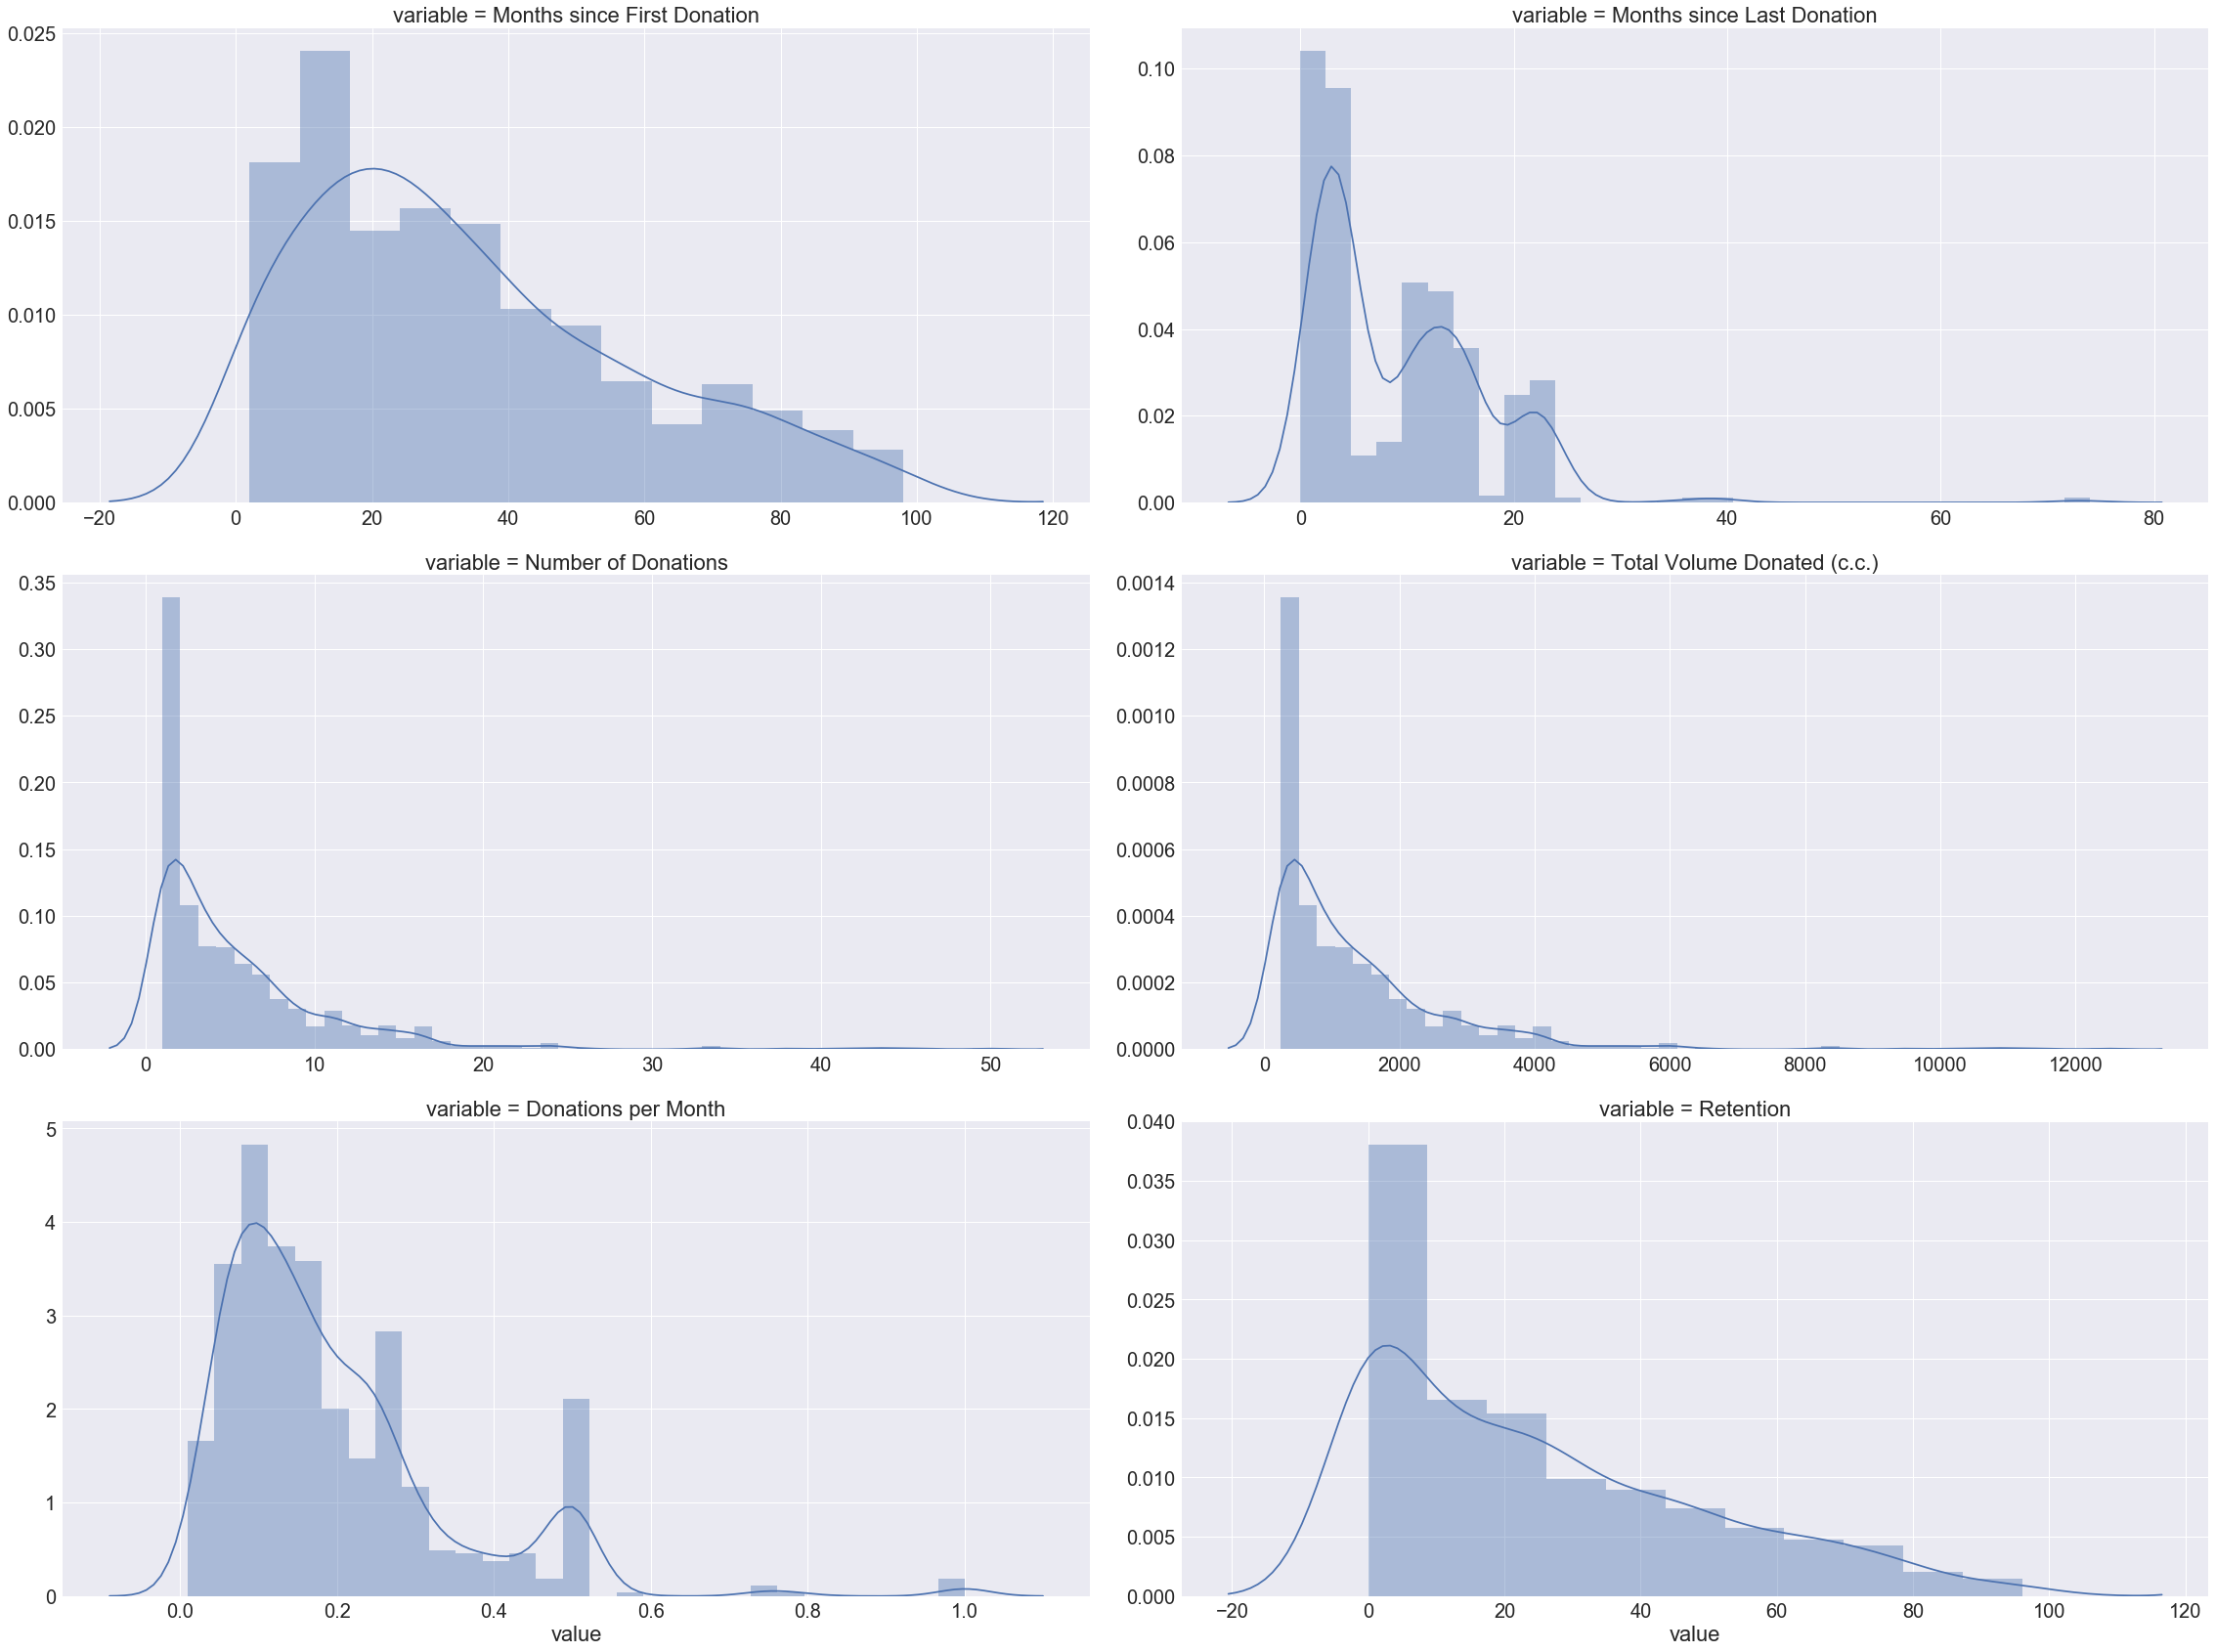

In [11]:
cols = merged.columns[1:]
# Distribution of the variables
sns.set(font_scale=2)
f = pd.melt(merged, value_vars=cols)
g = sns.FacetGrid(f, col="variable",  
                  col_wrap=2,
                  sharex=False,
                  sharey=False,
                  size=8,
                  aspect=2)
g = g.map(sns.distplot, "value")

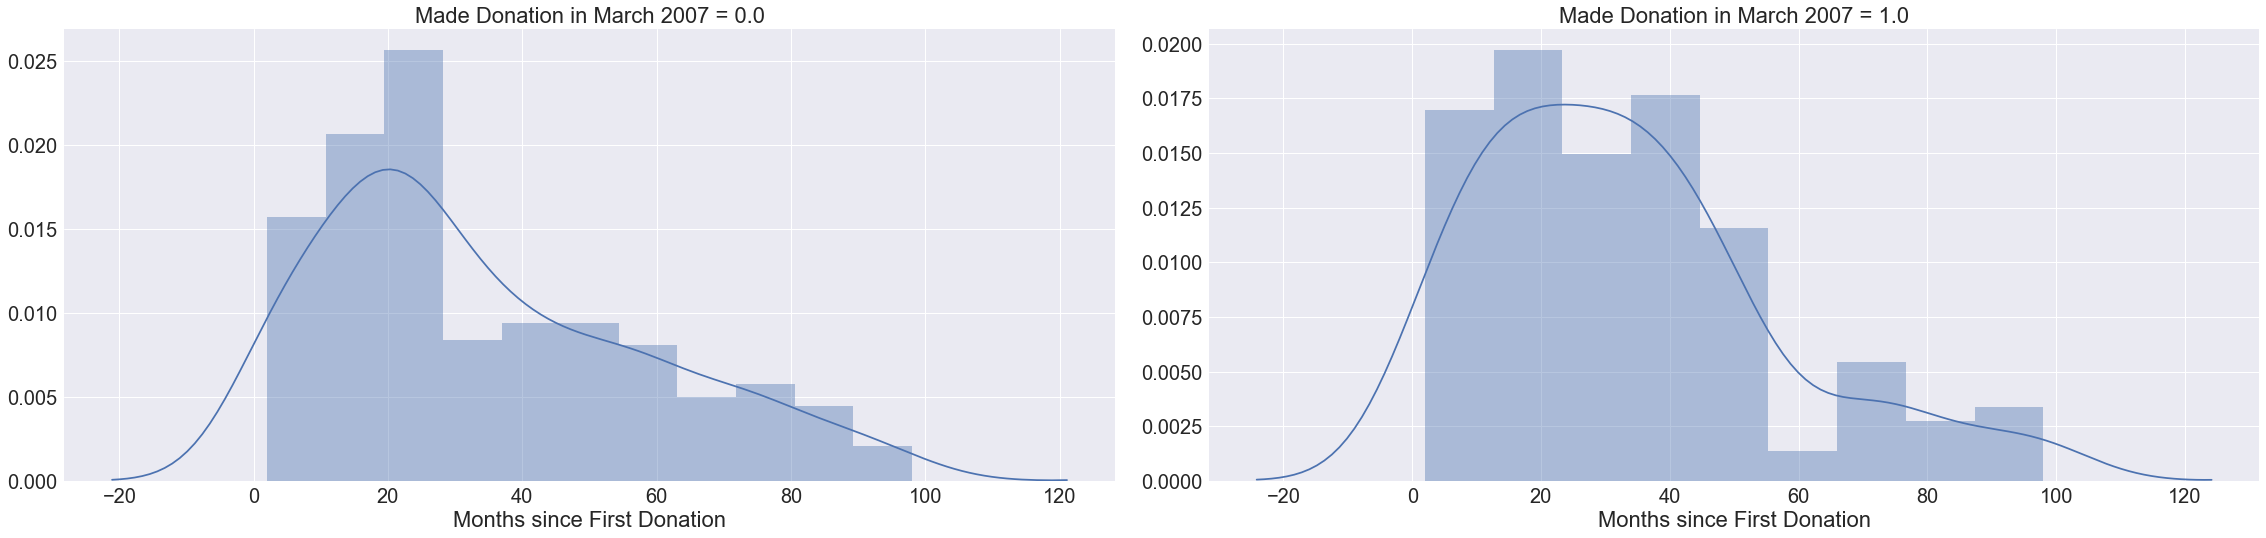

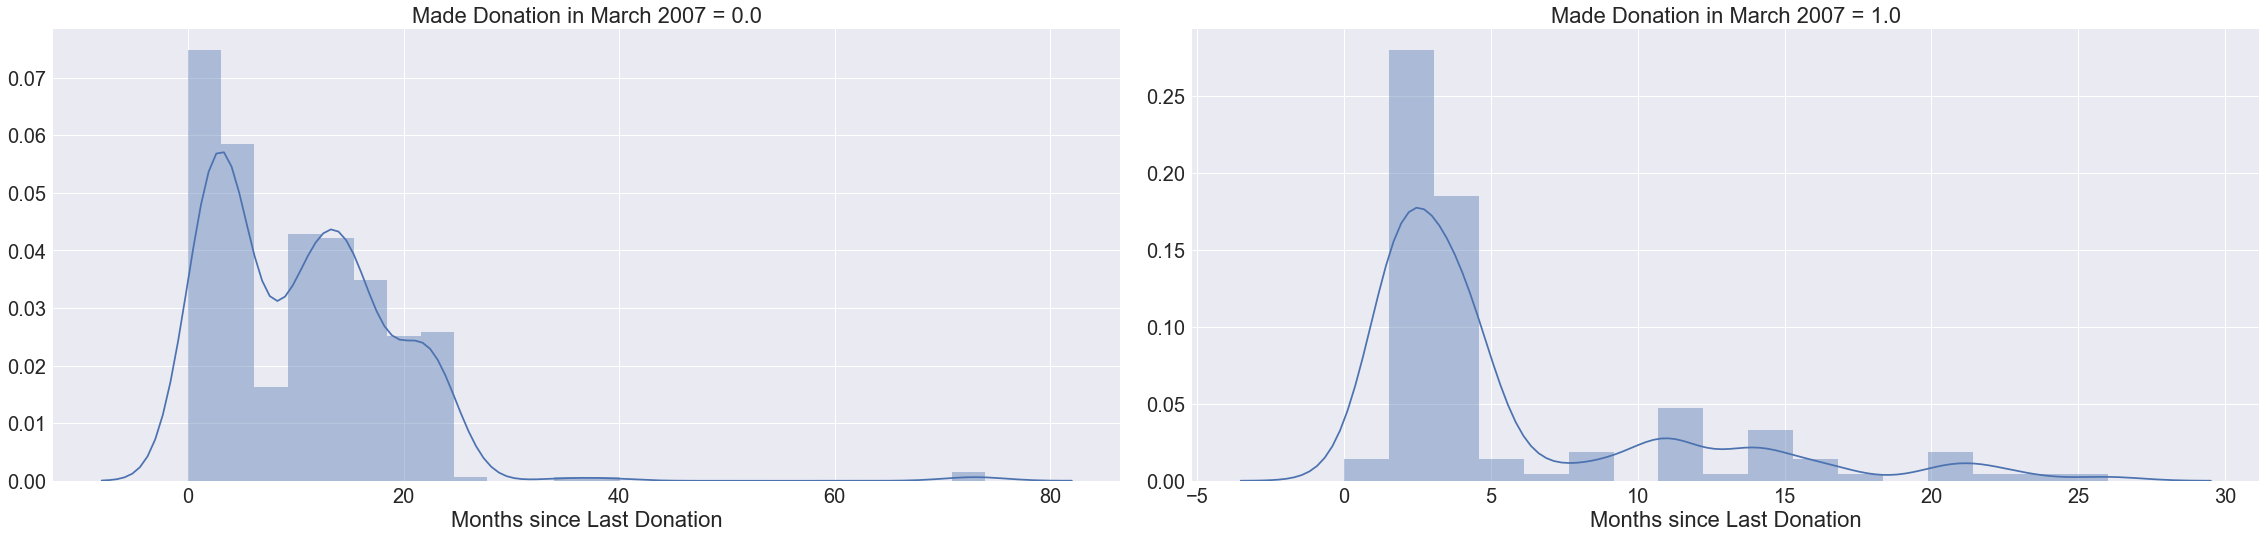

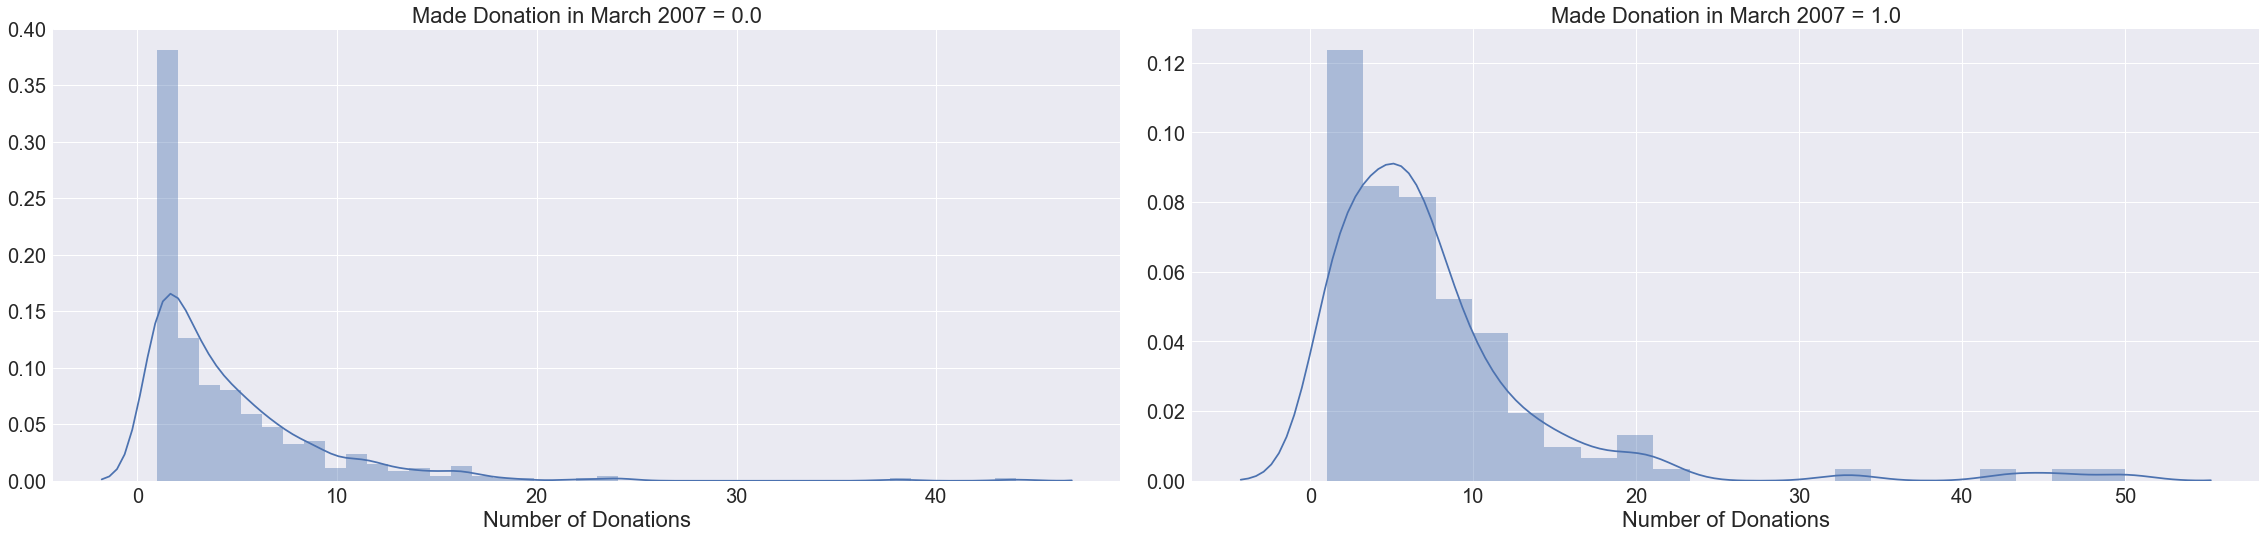

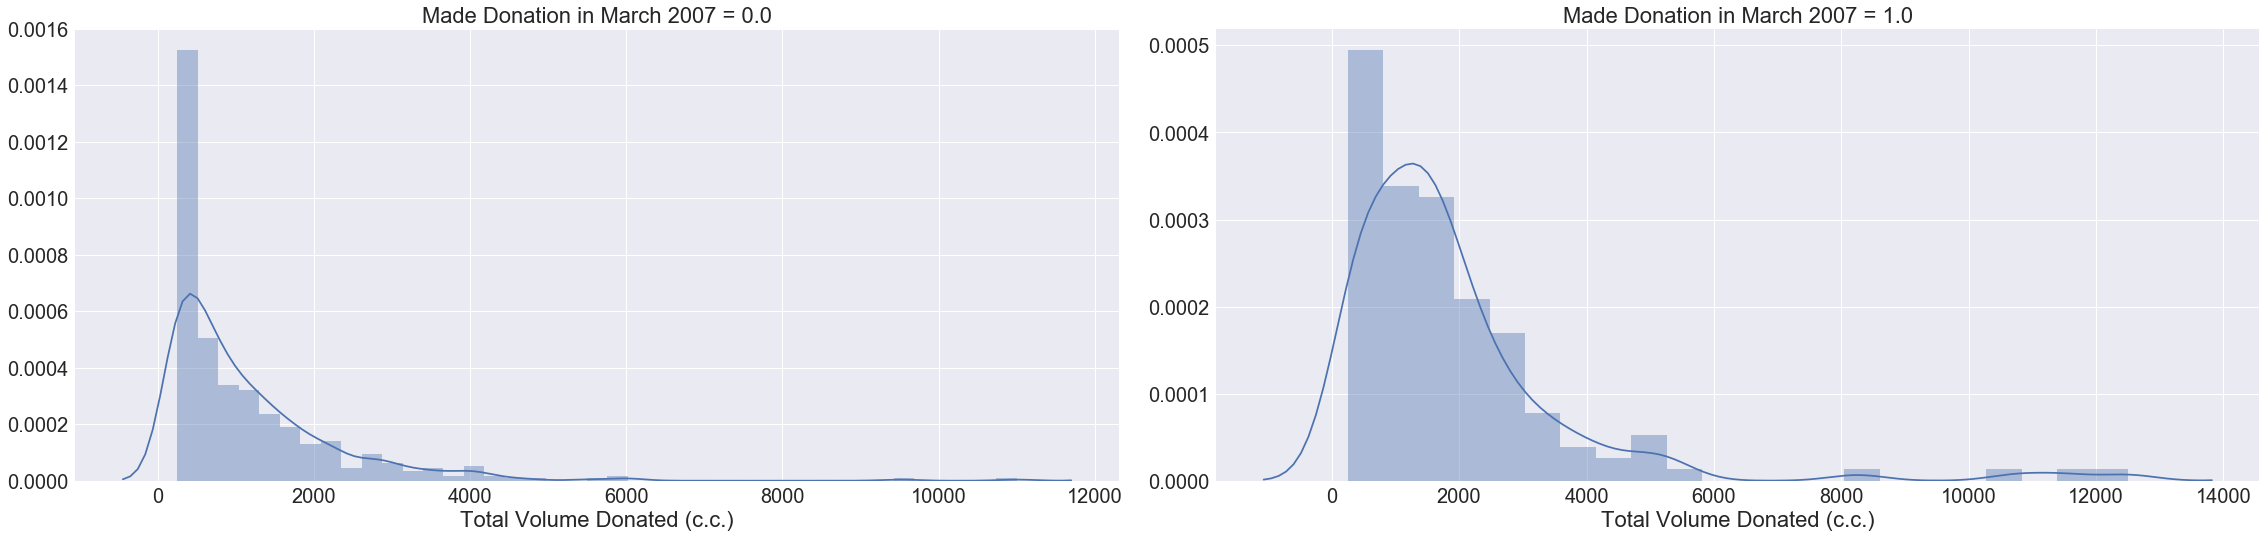

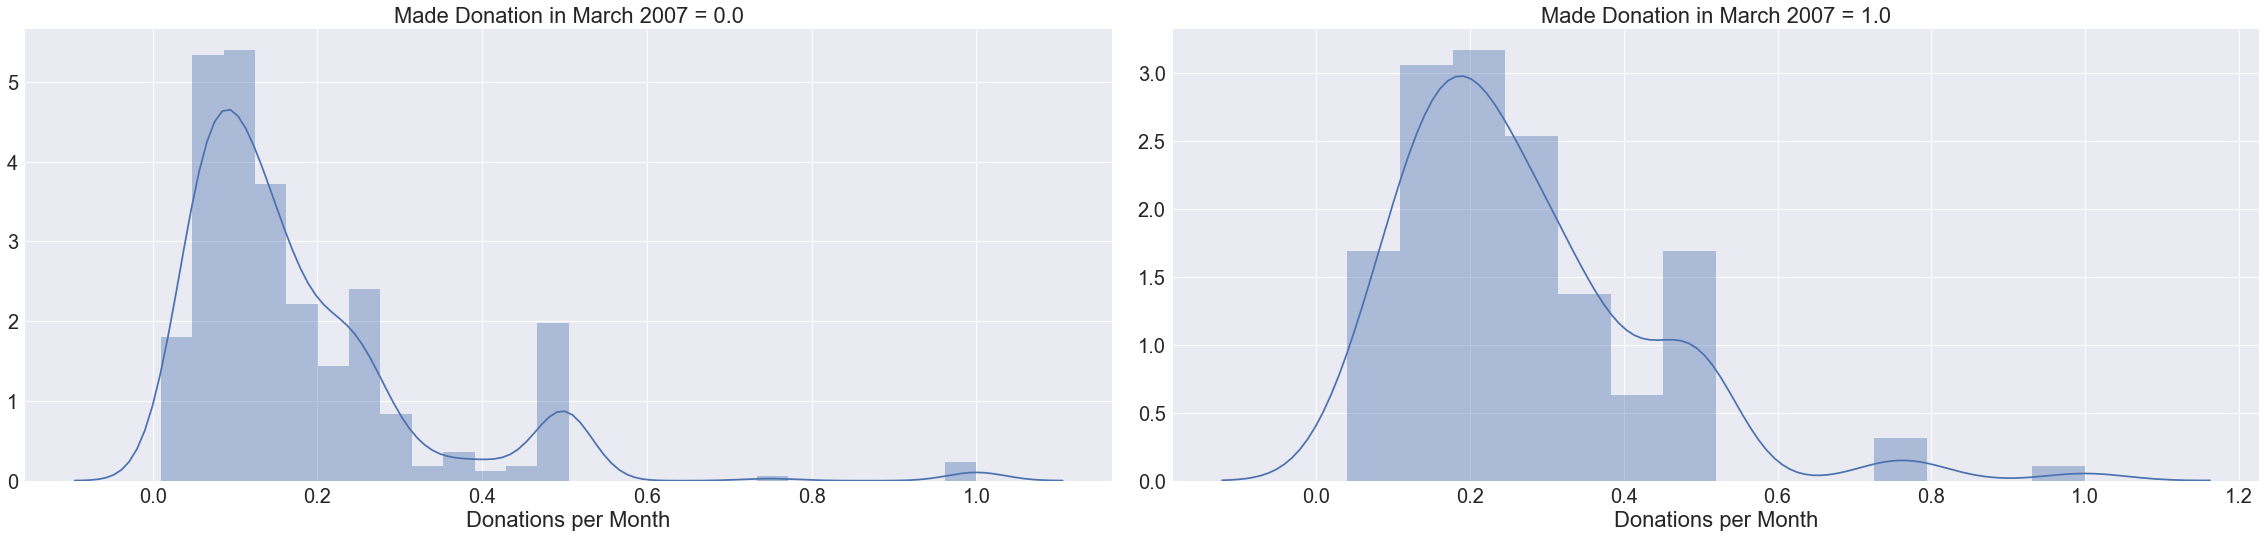

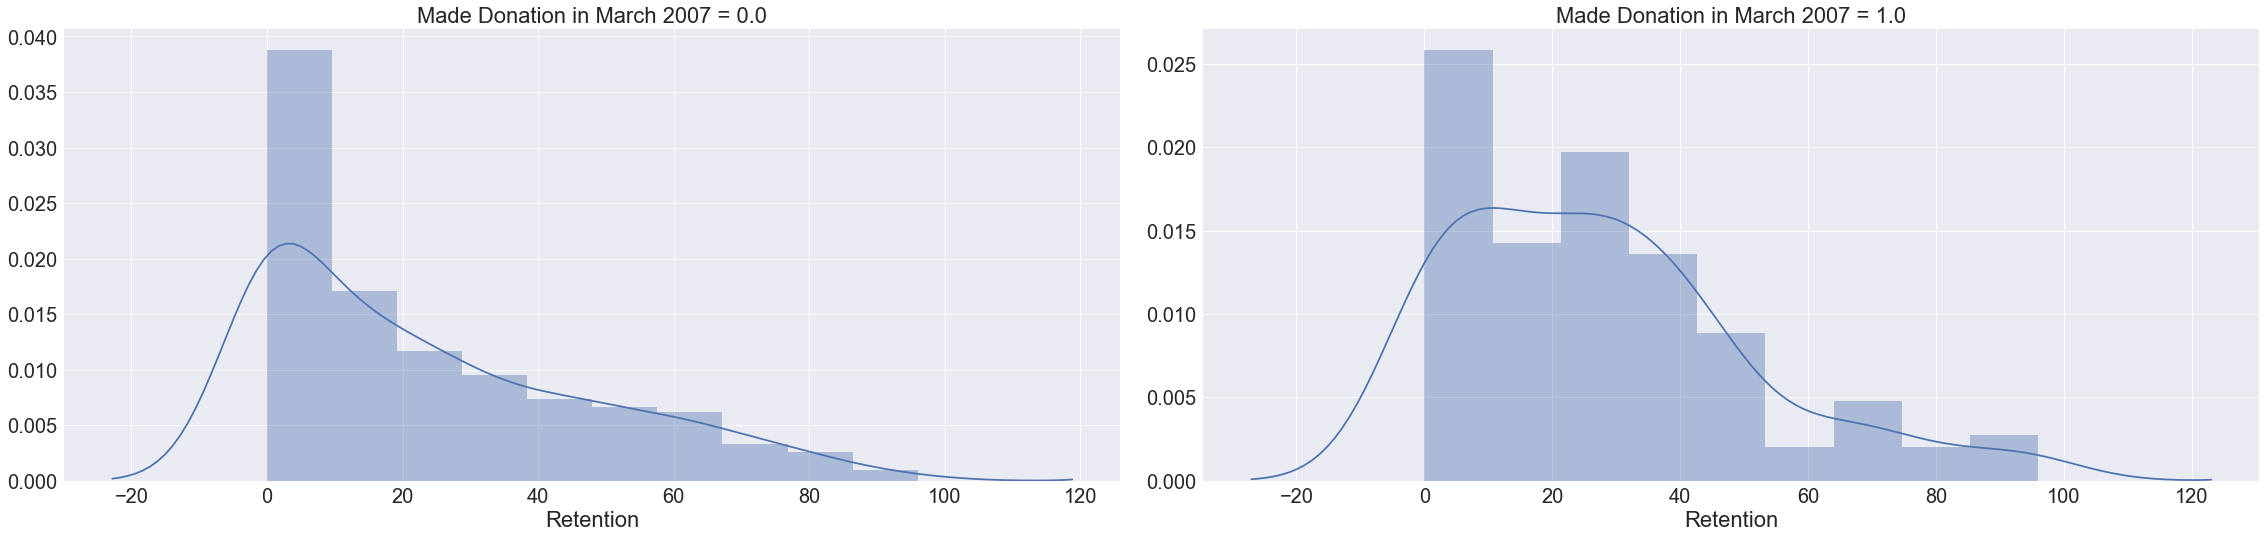

In [12]:
# Distribution of the variables for each class label
cols = merged.columns[1:]
for col in cols:
    g = sns.FacetGrid(merged, col='Made Donation in March 2007',
                      col_wrap=2,
                      sharex=False,
                      sharey=False,
                      size=8,
                      aspect=2)
    g = g.map(sns.distplot, col)

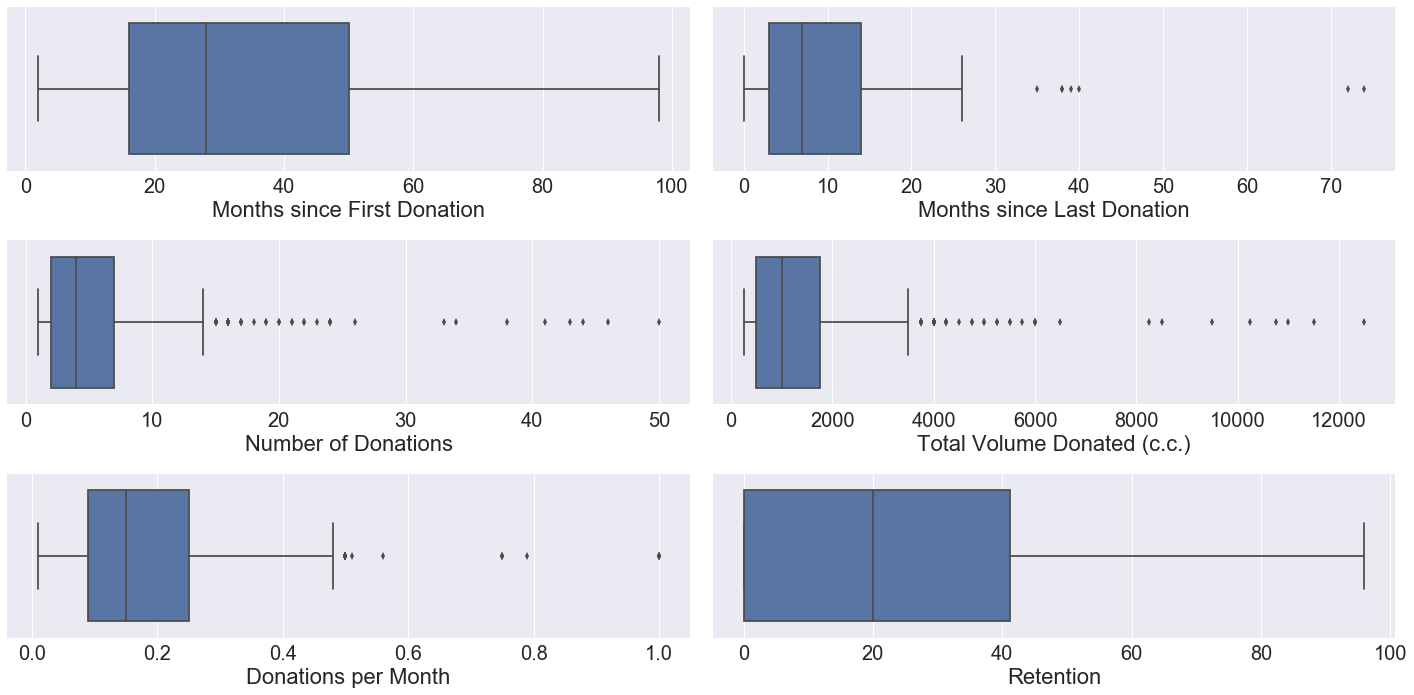

In [13]:
# Box plots - Independent variables
cols = merged.columns[1:]
fig, axis = plt.subplots(3, 2, figsize=(20,10))
sns.set(font_scale=1.5)

for i, ax in enumerate(axis.flatten()):
    sns.boxplot(x=merged[cols[i]], 
                ax=ax)
plt.tight_layout()

In [14]:
merged.loc[(merged['Total Volume Donated (c.c.)'] >= 10000)]

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Donations per Month,Retention
0,1.0,98,2,50,12500,0.51,96
8,1.0,98,5,46,11500,0.47,93
386,1.0,86,2,43,10750,0.50,84
388,0.0,98,2,44,11000,0.45,96
173,NaN,98,2,41,10250,0.42,96


In [15]:
merged.loc[(merged['Number of Donations'] > 40)]

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Donations per Month,Retention
0,1.0,98,2,50,12500,0.51,96
8,1.0,98,5,46,11500,0.47,93
386,1.0,86,2,43,10750,0.50,84
388,0.0,98,2,44,11000,0.45,96
173,NaN,98,2,41,10250,0.42,96


High values for Total Volume Donated (c.c.) and Total Volume Donated (c.c.) are likely not down to errors. As we would expect the records with a high number of donations have a higher total volume donated.

In [16]:
# VIF graphs to identify multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

iv_feats = merged.drop(['Made Donation in March 2007'], axis = 1)

vif = []
for i in range(1,len(add_constant(iv_feats).columns)):
    vif.append(variance_inflation_factor(add_constant(iv_feats).values, i))
    
vif = np.array(vif)

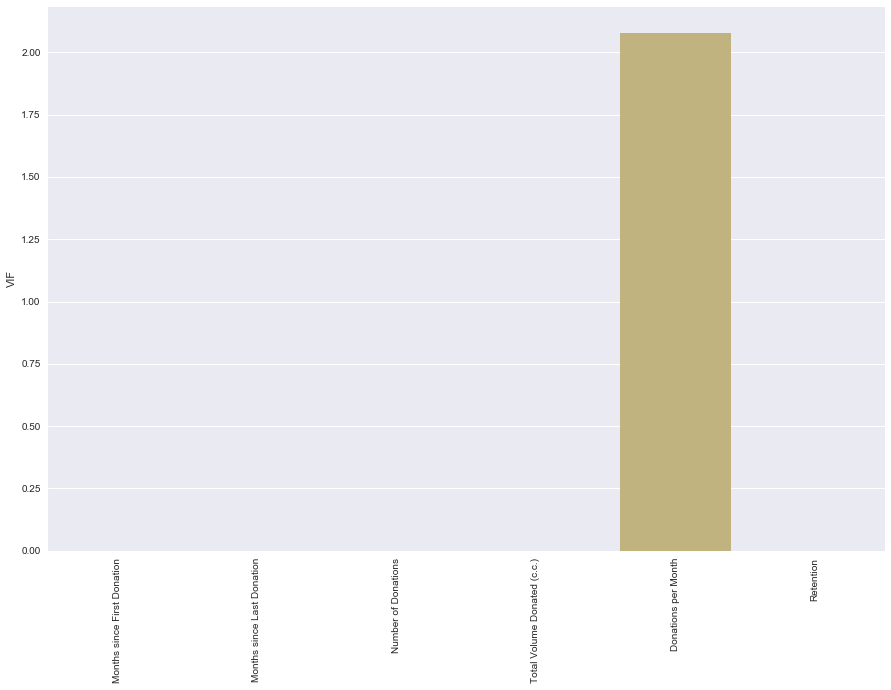

In [17]:
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(iv_feats.columns.values, vif)
ax.set_ylabel('VIF')
plt.xticks(rotation=90)
plt.show()

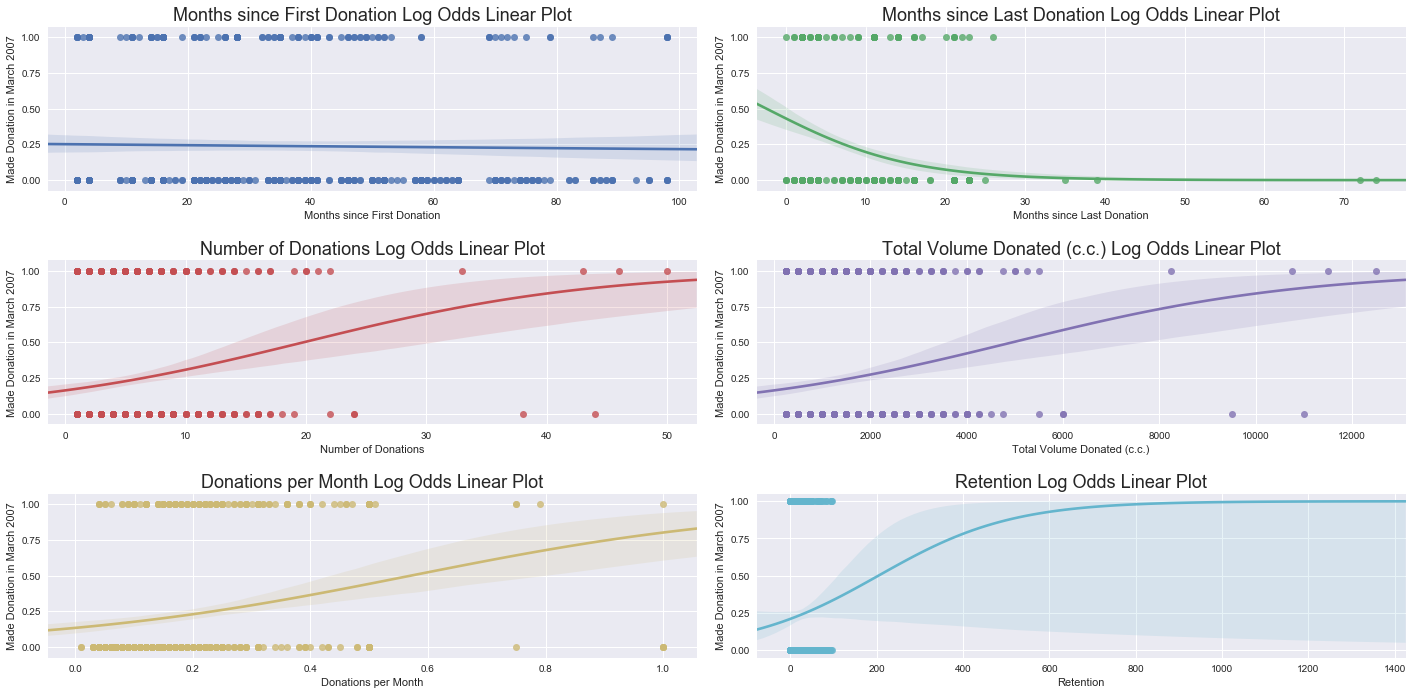

In [18]:
# Log Odds Linear Plot
train_df = merged[:trainlen]

X = train_df.columns[1:]
y = train_df.columns[0]
fig, axis = plt.subplots(3, 2, figsize=(20,10))
sns.set(font_scale=1.5)

for i, ax in enumerate(axis.flatten()):
    sns.regplot(x= train_df[X[i]], y= train_df[y], logistic= True, ax=ax).set_title(X[i] + " Log Odds Linear Plot")
plt.tight_layout()

In [19]:
corr = merged.corr()
corr

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Donations per Month,Retention
Made Donation in March 2007,1.000000,-0.019819,-0.261234,0.220615,0.220615,0.240788,0.068756
Months since First Donation,-0.019819,1.000000,0.164829,0.639148,0.639148,-0.329729,0.946045
Months since Last Donation,-0.261234,0.164829,1.000000,-0.176084,-0.176084,-0.497538,-0.163666
Number of Donations,0.220615,0.639148,-0.176084,1.000000,1.000000,0.243157,0.697122
Total Volume Donated (c.c.),0.220615,0.639148,-0.176084,1.000000,1.000000,0.243157,0.697122
Donations per Month,0.240788,-0.329729,-0.497538,0.243157,0.243157,1.000000,-0.166338
Retention,0.068756,0.946045,-0.163666,0.697122,0.697122,-0.166338,1.000000


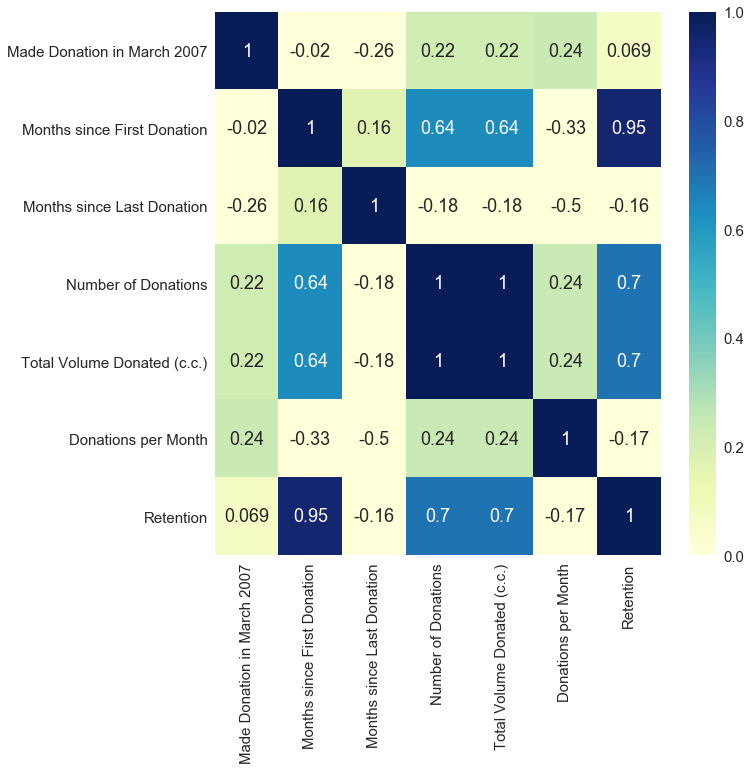

In [20]:
f, axs = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=0, vmax=1, annot=True, cmap='YlGnBu', ax=axs)
plt.yticks(rotation=0)
plt.show()

In [21]:
train_df.dtypes

Made Donation in March 2007    float64
Months since First Donation      int64
Months since Last Donation       int64
Number of Donations              int64
Total Volume Donated (c.c.)      int64
Donations per Month            float64
Retention                        int64
dtype: object

# Feature Engineering Cont. - Model performs better without Log Transformation

In [22]:
# Apply a log transformation to the features to get a normal distribution
cols = merged.columns[1:]

for col in cols:
    if col not in ('Unnamed: 0'):
        merged[col] = merged[col].apply(lambda x: np.log(x))
merged.head()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Donations per Month,Retention
0,1.0,4.584967,0.693147,3.912023,9.433484,-0.673345,4.564348
1,1.0,3.332205,-inf,2.564949,8.086410,-0.776529,3.332205
2,1.0,3.555348,0.000000,2.772589,8.294050,-0.776529,3.526361
3,1.0,3.806662,0.693147,2.995732,8.517193,-0.820981,3.761200
4,0.0,4.343805,0.000000,3.178054,8.699515,-1.171183,4.330733


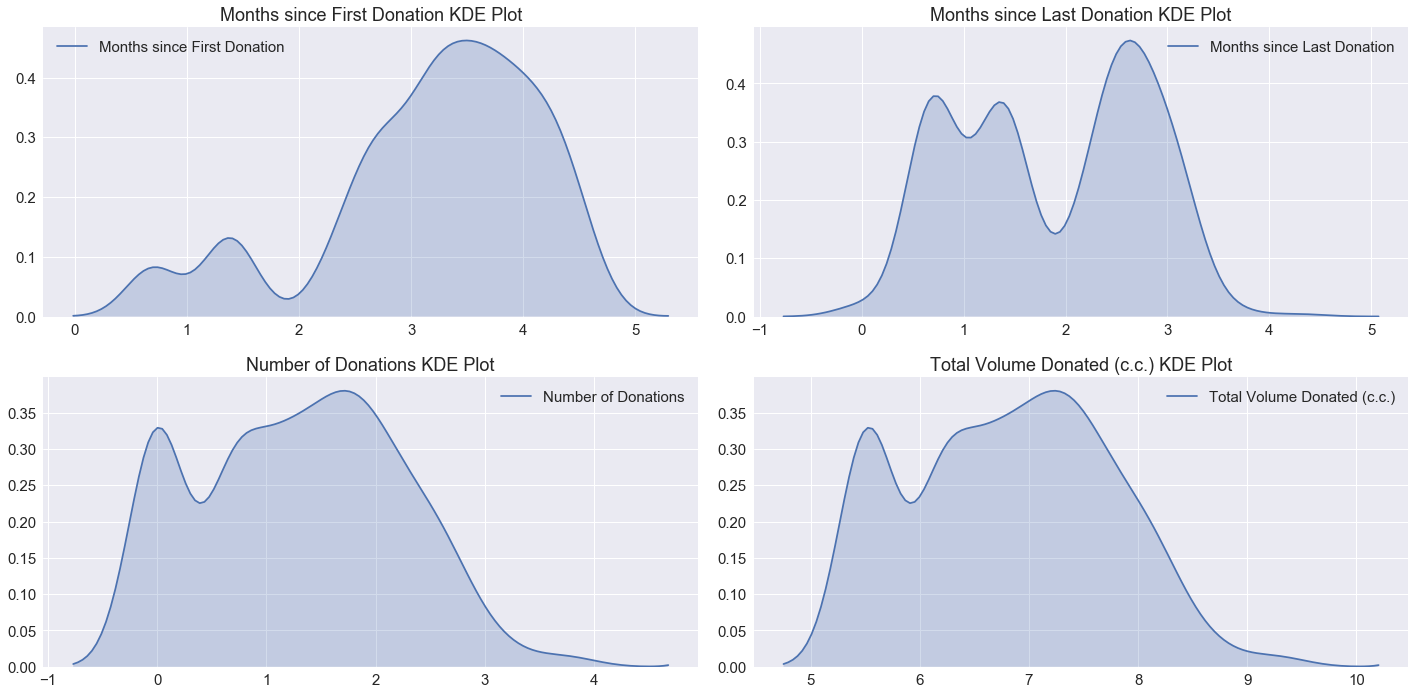

In [23]:
cols = merged.columns[1:-2]

fig, axis = plt.subplots(2, 2, figsize=(20,10))
sns.set(font_scale=1.5)

for i, ax in enumerate(axis.flatten()):
    sns.kdeplot(data = merged[cols[i]], shade=True, ax=ax).set_title(cols[i] + " KDE Plot")
plt.tight_layout()

Text(0.5,1,'Donations per Month KDE Plot')

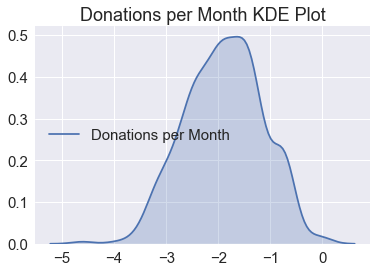

In [24]:
sns.kdeplot(data = merged['Donations per Month'], shade=True).set_title(merged['Donations per Month'].name + " KDE Plot")

In [25]:
#Fill -inf values
from numpy import inf

for col in merged.columns[1:]:
    merged[col].replace(-np.inf, 0, inplace = True)
    merged[col] = merged[col].astype(np.int64)
merged.dtypes

Made Donation in March 2007    float64
Months since First Donation      int64
Months since Last Donation       int64
Number of Donations              int64
Total Volume Donated (c.c.)      int64
Donations per Month              int64
Retention                        int64
dtype: object

# Model 

In [26]:
# Shuffle the data
train_df = merged[:trainlen]
train_df = train_df.sample(frac=1, random_state=RANDOM_STATE)
train_df = train_df.sample(frac=1, random_state=RANDOM_STATE)
train_df = train_df.sample(frac=1, random_state=RANDOM_STATE)

In [27]:
# Label encode target variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train_df['Made Donation in March 2007'] = le.fit_transform(train_df['Made Donation in March 2007'])
train_df['Made Donation in March 2007'] = train_df['Made Donation in March 2007'].astype('category')

In [28]:
test_df = merged[trainlen:]

In [29]:
test_df.head()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Donations per Month,Retention
0,NaN,3,0,2,8,-1,3
1,NaN,3,3,1,7,-1,2
2,NaN,1,1,0,5,-1,0
3,NaN,3,2,2,7,-1,3
4,NaN,3,1,2,8,-1,3


In [30]:
from sklearn.model_selection import train_test_split

X = train_df.drop(['Made Donation in March 2007','Number of Donations'], axis = 1)
y = train_df['Made Donation in March 2007']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [31]:
# Similar class distributions for both train and test sets
y = y.copy().astype(np.int64)

train_class = np.bincount(y_train)*100/len(y_train)
test_class = np.bincount(y_test)*100/len(y_test)

print(f'Train class Distribution: {train_class} \nTest class Distribution: {test_class}')

Train class Distribution: [76.08695652 23.91304348] 
Test class Distribution: [75.86206897 24.13793103]


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([('polynomial_features', PolynomialFeatures(degree=3)),
                  ('scaler', StandardScaler()),
                  ('logit' , LogisticRegression(C=1e9))
                 ])

In [33]:
model.fit(X_train, y_train)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [34]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=6)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.78 (+/- 0.07)


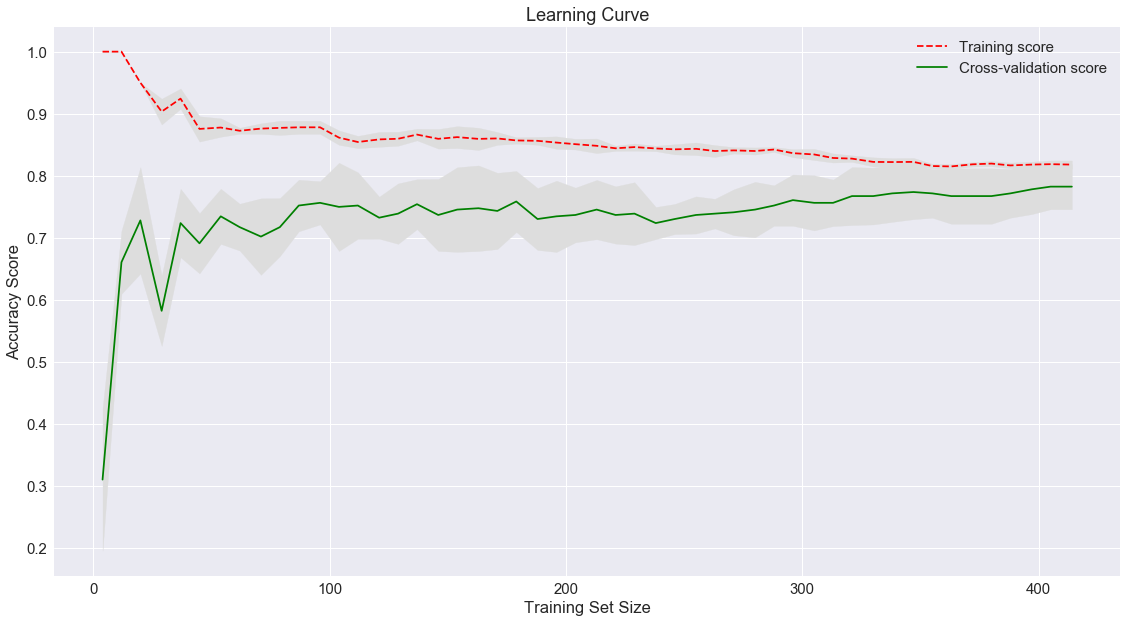

In [35]:
# Learning Curve

from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(model, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.rcParams["figure.figsize"] = [16,9]
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="green", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Model Evaluation

Text(0.5,1,'Logit Classifier')

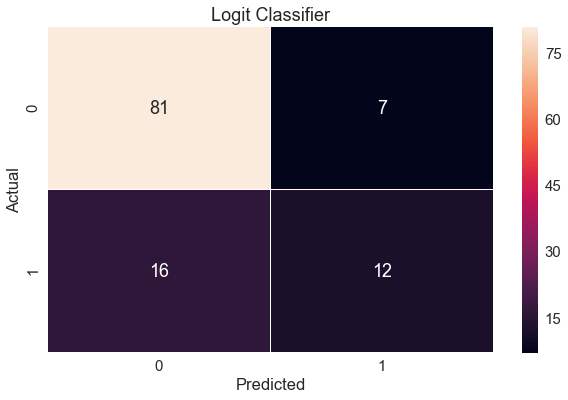

In [36]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(confusion, annot=True, fmt="d", linewidths=0.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Logit Classifier')

In [37]:
from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, roc_curve, classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.92      0.88        88
          1       0.63      0.43      0.51        28

avg / total       0.79      0.80      0.79       116



In [38]:
# Compute fpr, tpr, thresholds and roc auc
probs = model.predict_proba(X_test)
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

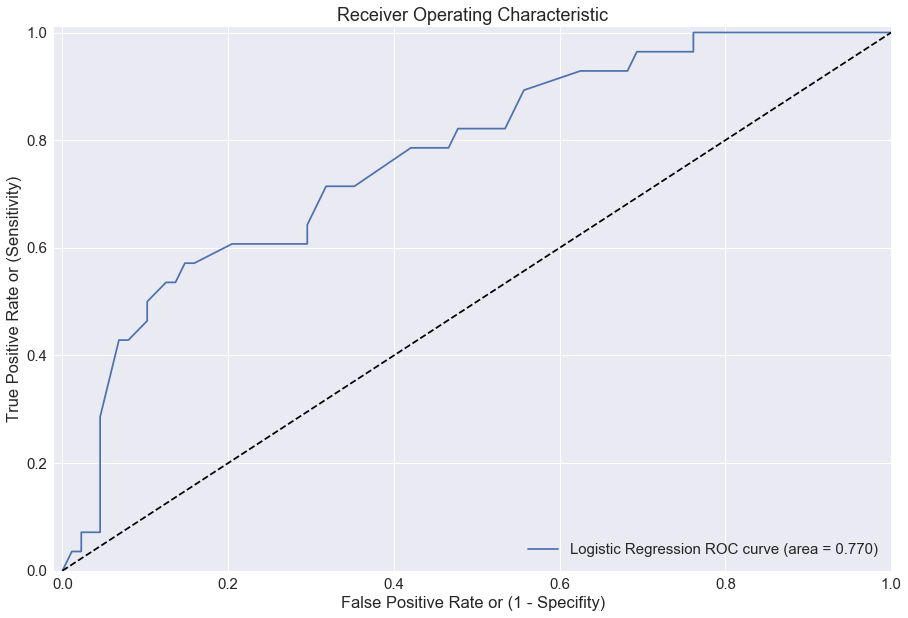

In [39]:
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, label='Logistic Regression ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [40]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

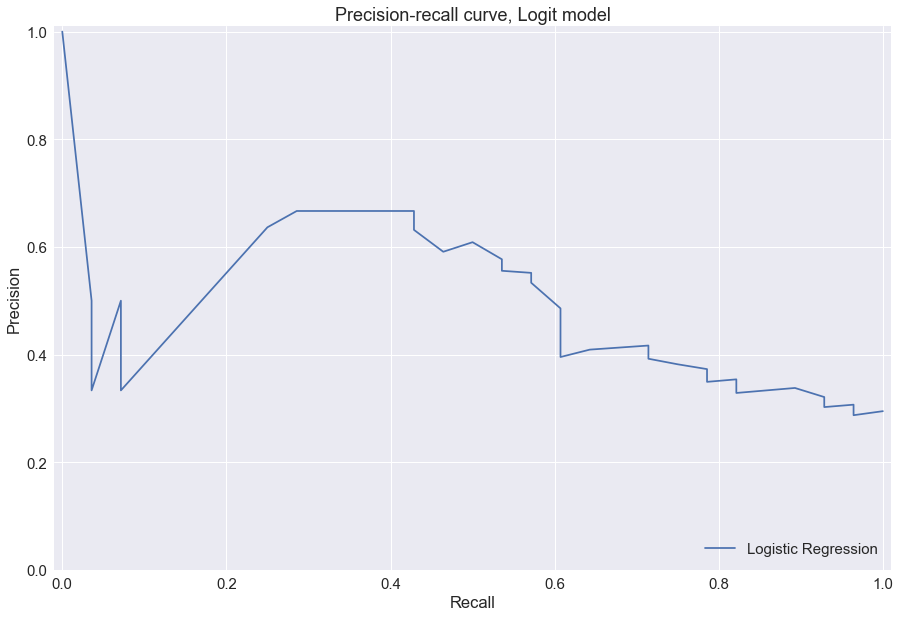

In [41]:
plt.figure(figsize=(15,10))
plt.plot(recall, precision, label='Logistic Regression')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve, Logit model')
plt.legend(loc="lower right")

In [42]:
test_df.head()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Donations per Month,Retention
0,NaN,3,0,2,8,-1,3
1,NaN,3,3,1,7,-1,2
2,NaN,1,1,0,5,-1,0
3,NaN,3,2,2,7,-1,3
4,NaN,3,1,2,8,-1,3


In [43]:
test_df.drop(['Made Donation in March 2007','Number of Donations'], axis = 1, inplace = True)

In [44]:
# extract probability donate = True

predictions = model.predict_proba(test_df)
predictions_donate = predictions[:,1]

In [45]:
submit = pd.DataFrame(test['Unnamed: 0'])

In [46]:
len(submit)

200

In [47]:
submit['Made Donation in March 2007'] = predictions_donate

In [48]:
submit.head()

,Unnamed: 0,Made Donation in March 2007
0,659,0.892976
1,276,0.000053
2,263,0.115058
3,303,0.182901
4,83,0.939587


In [49]:
submit = submit.rename(columns = {'Unnamed: 0':'Id'})

In [50]:
submit.to_csv('submission.csv', index=False)